<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Augment_comparison_GausianBlur1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#変更点
・Augment間の比較<br>
・画像にはcropped_2_imgを使用（png形式）

In [1]:
from __future__ import print_function, division
!pip install torch_optimizer

!pip install albumentations
import albumentations as A

!pip install ranger-adabelief==0.1.0
from ranger_adabelief import RangerAdaBelief

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil
import csv
import pandas as pd
import glob
from PIL import Image
import sys
import statistics
import time
import io


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

#あればGPUを使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi -L

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')



     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 631 kB 8.5 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=f0a870ad874c508b91e726270c16821cd67b94ca8de3e0220c136006a7f0e88e
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f9ef9094-df90-4c9b-6460-75f0d14daeaa)
Mounted at /content/drive


In [2]:
name = "disc_CLAHE"
model = "A2"
version = ""
if version is not "":
    version = "_"+str(version)

MODEL_NAME = name +"_"+model+version+"_pretrained"
DATASET_NAME = name+'_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
NET_NAME = "RepVGG_" +model  #RepVGG_A2 or RepVGG_B3
PRETRAINED = True

os.chdir(DATASET_PATH)

TRAIN_FOLDER_NAME = 'train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = 'val' #VALイメージのフォルダ
TEST_FOLDER_NAME = 'val' #VALイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result_4.csv' #年齢推定結果を書き出すcsv
FILENAME_RESULT_ANALYSISCSV = 'result_analysis_4.csv' #推定結果の解析結果を書き出すcsv


MODEL_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto/model'
#OPTIMIZER_PATH = "./optimizer_multi.pth"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16


# transforms param
PX = 224 #画像のサイズ

#cropped_CLAHE_img
NORMALIZE_AVE = [0.543, 0.353, 0.228]
NORMALIZE_STD = [0.135, 0.11,  0.072]

TRAIN_CROP_SCALE =(0.85,1.0)
TRAIN_BRIGHTNESS_PARAM = 0.2
TRAIN_CONTRAST_PARAM = 0.1
TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02


#csvファイルを開く
df_labelcsv = pd.read_csv(FILENAME_LABELCSV)

#csvファイルを表示
print(df_labelcsv)

#ID,ageの列の値をリストとして取り出す
df_filename = df_labelcsv['filename'].values
df_age = df_labelcsv['age'].values

#CSVファイル内の画像数
print(len(df_labelcsv))

"""
#画像フォルダ内の画像数
print(len(os.listdir(DATASET_NAME +"/"+ TRAIN_FOLDER_NAME))
+len(os.listdir(DATASET_NAME +"/"+ VAL_FOLDER_NAME))
+len(os.listdir(DATASET_NAME +"/"+ TEST_FOLDER_NAME)))
"""

                   filename  age
0     img00085008_00_1R.jpg   61
1     img00085024_00_1R.jpg   29
2     img00241280_10_1R.jpg   51
3     img00265140_00_1R.jpg   29
4     img00265140_00_2L.jpg   29
...                     ...  ...
1409  img76791392_10_1R.jpg   38
1410  img76843122_10_1R.jpg   49
1411  img76843122_11_1R.jpg   49
1412  img76888512_00_1R.jpg   74
1413  img76888512_00_2L.jpg   74

[1414 rows x 2 columns]
1414


'\n#画像フォルダ内の画像数\nprint(len(os.listdir(DATASET_NAME +"/"+ TRAIN_FOLDER_NAME))\n+len(os.listdir(DATASET_NAME +"/"+ VAL_FOLDER_NAME))\n+len(os.listdir(DATASET_NAME +"/"+ TEST_FOLDER_NAME)))\n'

#**Modules**

GaussianBlurNone
3.9 second
GaussianBlurNone
3.87 second
GaussianBlurNone
3.96 second
GaussianBlur3
3.86 second
GaussianBlur3
3.91 second
GaussianBlur3
3.89 second


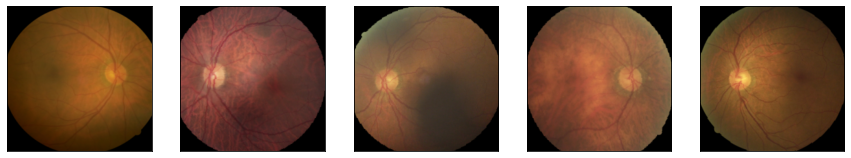

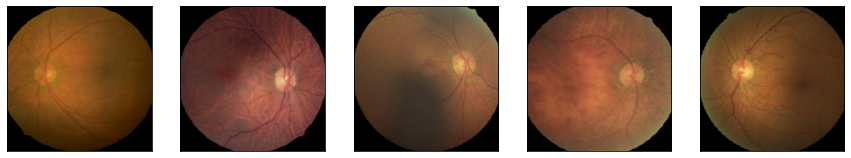

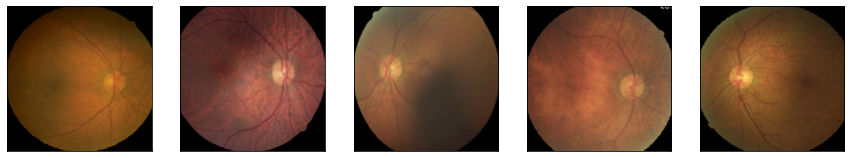

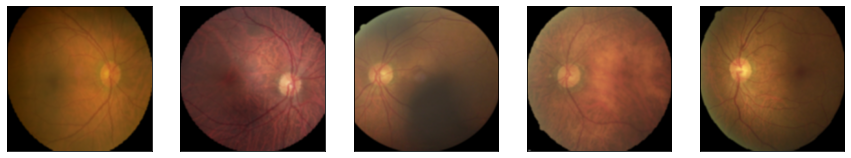

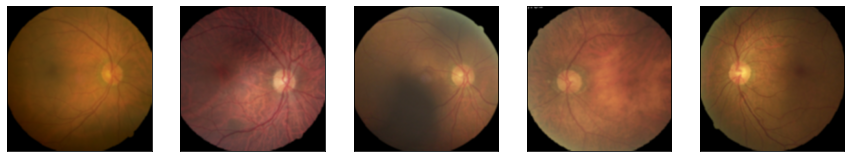

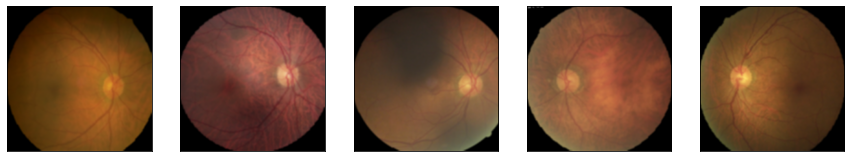

In [40]:
####################################
#Test with early-stopping
####################################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    #Optimize GPU computation
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0


        scaler = torch.cuda.amp.GradScaler(enabled=True)

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model

            with torch.cuda.amp.autocast(enabled=True):
                output = model(image_tensor)
                loss = loss_func(output, target)       
                # calculate the loss
                loss = loss_func(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            scaler.scale(loss).backward()
            # perform a single optimization step (parameter update)
            scaler.step(optimizer)

            # record training loss
            train_losses.append(loss.item())

            scaler.update()


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses



##################################
#Define RepVGG-B3
##################################


def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        num_ftrs = model_ft.linear.in_features  #in_featureはA2では1408、B3では2560
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.fc = nn.Linear(in_features=num_ftrs, out_features=1)  #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





#Calculating result

#対象のパスからラベルを抜き出して表示
def getlabel(result_csv, image_name):
      image_name = image_name
      label = df_result[df_result.iloc[:,0].str.contains(image_name)].iloc[0,1] #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得
      return(image_name, label)


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()])
    image_tensor = transform(image)


    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)


def my_round(x, d=0): #四捨五入
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p


#モデルにした処理した画像を投入して予測結果を出力
def image_eval(image_tensor, model_ft): 
    output = model_ft(image_tensor).item()*100
    return output

#result.csvに結果を記入
def write_result(df, image_name, pred, row):
    df.loc[df_result.iloc[:,0].str.contains(image_name), row] = pred  #df_resultよりimage_nameが含まれる行を抜き出して年齢を取得



#水増し後の画像を可視化する関数
def show_img(dataset):
    plt.figure(figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        #image = image.permute(1, 2, 0)
        image = image.numpy().transpose((1,2,0))
        image = np.clip(image, 0, 1)
        plt.subplot(1, 5, i+1)
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        plt.tick_params(bottom=False, left=False, right=False, top=False)
        plt.imshow(image)





#####################################
##### Datasets and Dataloader ############
#####################################

class SimpleImageDataset(Dataset):
    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.age = []

        for i in range(len(os.listdir(folder_path))):
              img_name = os.listdir(self.folder_path)[i]
              name = os.path.splitext(img_name)[0] #拡張子を削除したもの
              age_temp = df_labelcsv[df_labelcsv['filename'].str.contains(name)].iloc[0,1] #age
              self.age.append(float(age_temp)/100)

              img_path = os.path.join(self.folder_path, img_name)
              self.item_paths.append(img_path)
              #self.item_dict[image_path] = self.age


    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, idx):
        image_path = self.item_paths[idx]
        #pilr_image = read_image(image_path)
        pilr_image = Image.open(image_path)
        tensor_image = self.transform(pilr_image)
        target = torch.tensor([self.age[idx]])      
        return tensor_image, target


train_data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),        
                transforms.ToTensor(),
                ])

val_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                ])

test_data_transforms = transforms.Compose([
                transforms.Resize(PX),
                transforms.ToTensor(),
                ])




GaussianBlurNone =  transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                ])


GaussianBlur3 =  transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 30)),
                transforms.ToTensor(),
                ])

GaussianBlur7 = transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 30)),
                transforms.ToTensor(),
                ])

GaussianBlur11 = transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=11, sigma=(0.1, 30)), 
                transforms.ToTensor(),
                ])

GaussianBlur15  = transforms.Compose([
                transforms.RandomResizedCrop(250, scale=TRAIN_CROP_SCALE),
                transforms.RandomRotation(degrees=10),
                transforms.CenterCrop(PX),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=15, sigma=(0.1, 30)),
                transforms.ToTensor(),
                ])

transform_comparison = [GaussianBlurNone, GaussianBlurNone, GaussianBlurNone, GaussianBlur3, GaussianBlur3, GaussianBlur3]
transform_comparison_name = ["GaussianBlurNone", "GaussianBlurNone", "GaussianBlurNone", "GaussianBlur3", "GaussianBlur3", "GaussianBlur3"]



#画像の可視化
for i,j in zip(transform_comparison, transform_comparison_name):

    start_time = time.time()

    train_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, TRAIN_FOLDER_NAME), FILENAME_LABELCSV, i)
    print(str(j))
    show_img(train_dataset)

    elapsed_time = round(time.time() - start_time, 2)
    print(str(elapsed_time)+" second")



#**Data analysis**

In [ ]:
#ワンタッチ解析（process, model(A2/B3), dataset(cropped, disc, macula, vascular))
#ここからがメイン
start_time = time.time()

name = "cropped_2"
#name = ["cropped_CLAHE", "disc_CLAHE", "macula_CLAHE", "vascular_CLAHE"]
repvgg_model = ["A2"]
#repvgg_model = ["A2", "B3"]
version = ""
if version is not "":
    version = "_"+str(version)

EPOCH = 50
PATIENCE = 10


for (b, c) in zip(transform_comparison, transform_comparison_name):
    for l in repvgg_model:
        print("Start "+str(c)+" analysis!")
        DATASET_NAME = str(name) +'_img_trainvaltest'
        MODEL_NAME = str(name) +"_"+str(l)+version+"_pretrained"
        NET_NAME = "RepVGG_" +str(l) #RepVGG_A2 or RepVGG_B3


        train_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, TRAIN_FOLDER_NAME), FILENAME_LABELCSV, train_data_transforms)
        val_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, VAL_FOLDER_NAME), FILENAME_LABELCSV,  val_data_transforms)
        test_dataset = SimpleImageDataset(os.path.join(DATASET_NAME, TEST_FOLDER_NAME), FILENAME_LABELCSV,  test_data_transforms)

        train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers=os.cpu_count(), pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers=os.cpu_count(), pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers=os.cpu_count(), pin_memory=True)


        #print(TRAIN_FOLDER_NAME + "_dataset_size：" + str(len(train_dataset)))
        #print(VAL_FOLDER_NAME + "_dataset_size：" + str(len(val_dataset)))

        ####################################
        #ConvNetの調整
        ####################################

        if NET_NAME == "RepVGG_A2":
            model_ft = create_RepVGG_A2(deploy=False)
            if PRETRAINED == True:
                model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-A2-train.pth'))
                print("Pretrained model downloaded")
            elif PRETRAINED == False:
                pass
            else:
                print("TrueあるいはFalseで指定して下さい")
                sys.exit(1)

        elif NET_NAME == "RepVGG_B3":
            model_ft = create_RepVGG_B3(deploy=False)
            if PRETRAINED == True:
                model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Deep_learning/RepVGG-B3-200epochs-train.pth'))
                print("Pretrained model downloaded")
            elif PRETRAINED == False:
                pass
            else:
                print("TrueあるいはFalseで指定して下さい")
                sys.exit(1)
        else:
            print("RepVGG_A2あるいはRepVGG_B3を指定して下さい")
            sys.exit(1)

        #model_ft.load_state_dict(torch.load(MODEL_PATH)) 
        model_ft = mod_RepVGG()

        #GPU使用
        model_ft = model_ft.to(device)

        #損失関数を定義
        loss_func = nn.MSELoss()

        #Optimizer
        #optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)
        """
        optimizer_ft = optim.AdaBound(
            model_ft.parameters(),
            lr= 1e-3,
            betas= (0.9, 0.999),
            final_lr = 0.1,
            gamma=1e-3,
            eps= 1e-8,
            weight_decay=0,
            amsbound=False,
        )
        """
        #optimizer_ft = AdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
        optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple = True)
        

        ####################################
        # Train and Save network
        ####################################

        model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)

        #ネットワークの保存
        #PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
        #torch.save(model_ft.state_dict(), PATH)

        ####################################
        # Result Analysis
        ####################################

        model_ft.eval() # prep model for evaluation

        outputs,targets,errors =[], [], []
        for image_tensor, target in test_loader:  
              target = target.view(len(target), 1)         
              image_tensor = image_tensor.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model_ft(image_tensor)

              outputs.append((output[0]*100).item())      
              targets.append((target[0]*100).item())
              #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

              errors.append((output[0]*100).item()-(target[0]*100).item())
        
        AbsError = [abs(i) for i in errors]
        MeanError = str(statistics.mean(errors))
        StdError = str(statistics.stdev(errors))
        MeanAbsError = str(statistics.mean(AbsError))
        StdAbsError = str(statistics.stdev(AbsError))

        print('MeanError: '+MeanError)
        print('StdError: '+StdError)
        print('MeanAbsError: '+MeanAbsError)
        print('StdAbsError: '+StdAbsError)


        #result_analysis.csv作成（ファイルがなければ）
        if os.path.exists(FILENAME_RESULT_ANALYSISCSV) == False:
            columns = []
            index = ["AveError", "StdError", "AveAbsError", "StdAbsError"]
            df_result_analysis = pd.DataFrame(index=index, columns=columns)
            df_result_analysis.to_csv(FILENAME_RESULT_ANALYSISCSV)
        else:
            print(FILENAME_RESULT_ANALYSISCSV + " already exists!")

        df_result_analysis = pd.read_csv(FILENAME_RESULT_ANALYSISCSV, index_col=0)
        df_result_analysis[MODEL_NAME+"_"+str(transform_comparison)] = [MeanError, StdError, MeanAbsError, StdAbsError]


        PATH = MODEL_PATH+'/'+MODEL_NAME+'.csv'
        df_result_analysis.to_csv(FILENAME_RESULT_ANALYSISCSV, index=True)
        

        """
        #result.csv作成（ファイルがなければ）
        if os.path.exists(FILENAME_RESULTCSV) == False:
            df_result = df_labelcsv.copy()
            df_result.to_csv(FILENAME_RESULTCSV, index=False)
        else:
            print(FILENAME_RESULTCSV + " already exists!")

        df_result = pd.read_csv(FILENAME_RESULTCSV)
        #print(df_result)
        print("Calculating prediction results!")

        #valフォルダ内のファイル名を取得
        train_data_path = glob.glob(DATASET_NAME + "/" +str(i) + "/" + TRAIN_FOLDER_NAME+"/*")
        val_data_path = glob.glob(DATASET_NAME + "/" + str(i) + "/" + VAL_FOLDER_NAME+"/*")

        data_path = [train_data_path, val_data_path]
        k=0
        for j in data_path:
            for m in j:
                  #print(m)
                  #print(os.path.splitext(os.path.basename(m))[0])
                  image_name, label = getlabel(df_result, os.path.splitext(os.path.basename(m))[0])  #画像の名前（拡張子なし）とラベルを取得
                  image_tensor = image_transform(m)  #予測のための画像下処理
                  pred = image_eval(image_tensor, model_ft)  #予測結果を出力   
                  write_result(df_result, image_name, pred, MODEL_NAME+"_"+str(i))
                  #print(str(k)+"/"+str(len(df_result)) + " images processed! label: "+str(label)+ " , pred: "+str(pred))
                  k+=1
        #print(df_result)

        #Resultファイルを書き出し
        df_result.to_csv(FILENAME_RESULTCSV, index=False)
        """

        # calculate elapsed time
        elapsed_time = int(time.time() - start_time)

        # convert second to hour, minute and seconds
        elapsed_hour = elapsed_time // 3600
        elapsed_minute = (elapsed_time % 3600) // 60
        elapsed_second = (elapsed_time % 3600 % 60)

        # print as 00:00:00
        print(str(elapsed_hour).zfill(2) + ":" + str(elapsed_minute).zfill(2) + ":" + str(elapsed_second).zfill(2))



Start GaussianBlurNone analysis!
RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_

#**Load network**

In [ ]:
name = "macula_2"
model = "A2"  #A2 or B3

MODEL_NAME = name +"_"+model+"_pretrained"
DATASET_NAME = name+'_img_trainval'
DATASET_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto'
NET_NAME = "RepVGG_" +model  #RepVGG_A2 or RepVGG_B3
PRETRAINED = True

TRAIN_FOLDER_NAME = 'train' #TRAINイメージのフォルダ
VAL_FOLDER_NAME = 'val' #VALイメージのフォルダ

FILENAME_LABELCSV = 'name_age.csv' #年齢の値のcsv
FILENAME_RESULTCSV = 'result_2.csv' #年齢推定結果を書き出すcsv
FILENAME_RESULT_ANALYSISCSV = 'result_analysis_2.csv' #推定結果の解析結果を書き出すcsv

MODEL_PATH = '/content/drive/MyDrive/Deep_learning/FundusPhoto/model'
#OPTIMIZER_PATH = "./optimizer_multi.pth"

if NET_NAME == "RepVGG_A2":
    model_ft = create_RepVGG_A2(deploy=False)

elif NET_NAME == "RepVGG_B3":
    model_ft = create_RepVGG_B3(deploy=False)

else:
    print("RepVGG_A2あるいはRepVGG_B3を指定して下さい")
    sys.exit(1)

#model_ft.load_state_dict(torch.load(MODEL_PATH)) 
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

In [ ]:
#ここからがメイン
process = [0,1,2,3,4]
for i in process:
    print("Start "+ str(i) + " th analysis!")

    #トレーニングしたパラメーターを適用
    PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
    model_ft.load_state_dict(torch.load(PATH))
    model_ft.eval()

    df_result = pd.read_csv(FILENAME_RESULTCSV)
    print(PATH)
    print("Calculating prediction results!")

    #valフォルダ内のファイル名を取得
    train_data_path = glob.glob(DATASET_NAME + "/" +str(i) + "/" + TRAIN_FOLDER_NAME+"/*")
    val_data_path = glob.glob(DATASET_NAME + "/" + str(i) + "/" + VAL_FOLDER_NAME+"/*")

    data_path = [train_data_path, val_data_path]
    preds,targets,errors =[], [], []
    k=0
    for j in data_path:
        for m in j:
              image_name, label = getlabel(df_result, os.path.splitext(os.path.basename(m))[0])  #画像の名前とラベルを取得
              image_tensor = image_transform(m)  #予測のための画像下処理
              pred = image_eval(image_tensor, model_ft)  #予測結果を出力   
              write_result(df_result, image_name, pred, MODEL_NAME+"_"+str(i))
              print(str(k)+"/"+str(len(df_result))+" th image: "+str(image_name)+", pred: "+str(my_round(pred, d=1))+", label: "+str(label))

              preds.append(pred)      
              targets.append(label)
              errors.append(pred-label)

              k+=1
    print(df_result)

    AbsError = [abs(i) for i in errors]
    MeanError = str(statistics.mean(errors))
    StdError = str(statistics.stdev(errors))
    MeanAbsError = str(statistics.mean(AbsError))
    StdAbsError = str(statistics.stdev(AbsError))
    print('MeanError: '+MeanError)
    print('StdError: '+StdError)
    print('MeanAbsError: '+MeanAbsError)
    print('StdAbsError: '+StdAbsError)
    print()

    #Resultファイルを書き出し
    df_result.to_csv(FILENAME_RESULTCSV, index=False)


In [ ]:
#######################
##1枚の画像のみを判定
#######################

print(MODEL_PATH)
print(MODEL_NAME)

#ファイル名を取得
img_name = "img00085008_00_1R.png"
img_path1 = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+name+"_img_trainval/0/train/"+img_name
img_path2 = "/content/drive/MyDrive/Deep_learning/FundusPhoto/"+name+"_img_trainval/0/val/"+img_name

for i in [img_path1, img_path2]:
    is_file = os.path.isfile(i)
    if is_file:
        img_path = i
        print("aaa")
    else:
        pass # パスが存在しないかファイルではない
        print("bbb")


outputs = []
for i in range(5):
    #トレーニングしたパラメーターを適用
    PATH = MODEL_PATH+'/'+MODEL_NAME+'_'+str(i)+'.pth'
    model_ft.load_state_dict(torch.load(PATH))
    model_ft.eval()

    df_result = pd.read_csv(FILENAME_RESULTCSV)
    print(MODEL_NAME+'_'+str(i)+'.pth')
    print("Calculating prediction results!")

    image_tensor = image_transform(img_path)  #予測のための画像下処理
    pred = image_eval(image_tensor, model_ft)  #予測結果を出力   

    outputs.append(pred)

print(outputs)

/content/drive/MyDrive/Deep_learning/FundusPhoto/model
macula_2_A2_pretrained
aaa
bbb
macula_2_A2_pretrained_0.pth
Calculating prediction results!
macula_2_A2_pretrained_1.pth
Calculating prediction results!
macula_2_A2_pretrained_2.pth
Calculating prediction results!
macula_2_A2_pretrained_3.pth
Calculating prediction results!
macula_2_A2_pretrained_4.pth
Calculating prediction results!
[44.820716977119446, 68.22026371955872, 54.96704578399658, 54.79089617729187, 50.11647343635559]
